# Step 1: Install Requirements

In [2]:
#clone YOLOv5 and 
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow

import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5'...
remote: Enumerating objects: 12192, done.
remote: Total 12192 (delta 0), reused 0 (delta 0), pack-reused 12192
Receiving objects: 100% (12192/12192), 11.91 MiB | 22.37 MiB/s, done.
Resolving deltas: 100% (8441/8441), done.
/content/yolov5/yolov5
Setup complete. Using torch 1.11.0+cu113 (Tesla T4)


In [3]:
from roboflow import Roboflow
rf = Roboflow(model_format="yolov5", notebook="ultralytics")

upload and label your dataset, and get an API KEY here: https://app.roboflow.com/?model=yolov5&ref=ultralytics


In [4]:
# set up environment
os.environ["DATASET_DIRECTORY"] = "/content/datasets"

In [5]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="cVEtmQca6JMsH0rWK9rV")
project = rf.workspace("sudips-workspace").project("license-plate-detection-x9ngg")
dataset = project.version(1).download("yolov5")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to /content/datasets/License-plate-detection-1 in yolov5pytorch:: 100%|██████████| 2108/2108 [00:02<00:00, 798.98it/s] 


# Step 3: Train Our Custom YOLOv5 model

Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** Our dataset locaiton is saved in the `dataset.location`
- **weights:** specify a path to weights to start transfer learning from. Here we choose the generic COCO pretrained checkpoint.
- **cache:** cache images for faster training

In [6]:
!python train.py --img 416 --batch 16 --epochs 150 --data {dataset.location}/data.yaml --weights yolov5s.pt --cache

train: weights=yolov5s.pt, cfg=, data=/content/datasets/License-plate-detection-1/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=150, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-246-g2dd3db0 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, h

# Evaluate Custom YOLOv5 Detector Performance
Training losses and performance metrics are saved to Tensorboard and also to a logfile.

If you are new to these metrics, the one you want to focus on is `mAP_0.5` - learn more about mean average precision 

In [11]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
#%load_ext tensorboard
#%tensorboard --logdir runs

#Run Inference  With Trained Weights


In [15]:
!python detect.py --weights runs/train/exp/weights/best.pt --img 416 --conf 0.1 --source /content/image.jpg

detect: weights=['runs/train/exp/weights/best.pt'], source=/content/image.jpg, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-246-g2dd3db0 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/image.jpg: 320x416 1 License-Plate, Done. (0.015s)
Speed: 0.4ms pre-process, 14.5ms inference, 1.2ms NMS per image at shape (1, 3, 416, 416)
Results saved to runs/detect/exp2


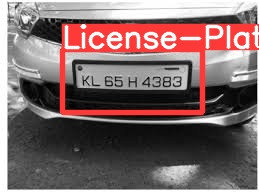

In [14]:
#display inference on ALL test images

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/image.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

In [24]:
#export your model's weights for future use
from google.colab import files
files.download('./runs/train/exp/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
pip install requests pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
import io
import cv2
import requests
from PIL import Image
from requests_toolbelt.multipart.encoder import MultipartEncoder

# Load Image with PIL
img = cv2.imread("/content/image.jpg")
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pilImage = Image.fromarray(image)

# Convert to JPEG Buffer
buffered = io.BytesIO()
pilImage.save(buffered, quality=100, format="JPEG")

# Build multipart form and post request
m = MultipartEncoder(fields={'file': ("imageToUpload", buffered.getvalue(), "image/jpeg")})

response = requests.post("https://detect.roboflow.com/license-plate-detection-x9ngg/1?api_key=cVEtmQca6JMsH0rWK9rV", data=m, headers={'Content-Type': m.content_type})

print(response)
print(response.json())
#cv2_imshow(img)

<Response [200]>
{'predictions': [{'x': 124.5, 'y': 79.5, 'width': 129, 'height': 49, 'class': 'License-Plate', 'confidence': 0.424}]}


In [18]:
dic={}
dic=response.json()
out=dic['predictions']
for i in out:
  cls=i['class']
  confidence=i['confidence']
  x=float(i['x'])
  y=float(i['y'])
  w=float(i['width'])
  h=float(i['height'])
print('x=',x,'y=',y,'w=',w,'h=',h)

x= 124.5 y= 79.5 w= 129.0 h= 49.0


# **Visualization of license plate frame**

<class 'numpy.ndarray'>
Shape of the image (195, 259, 3)


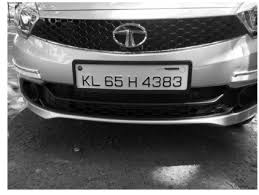

Cropped Image


In [19]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread("/content/image.jpg")
print(type(img))
# Shape of the image
print("Shape of the image", img.shape)
# [rows, columns]
crop = img[int(y)-10:int(y+h)-30, int(x)-50:int(x+w)-55]
cv2_imshow(img)
print('Cropped Image')
cv2_imshow(crop)
#display(Image(crop))
cv2.waitKey(0)
cv2.destroyAllWindows()

In [20]:
crop.shape

(29, 124, 3)

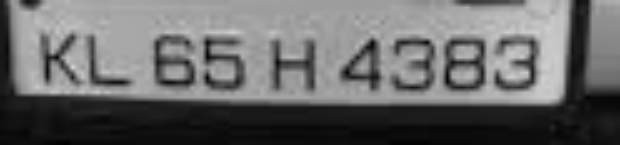

In [21]:
def zoom(img, zoom_factor=1.5):
    return cv2.resize(img, None, fx=zoom_factor, fy=zoom_factor)
zoomed = zoom(crop, 5)
cv2.imwrite('zoomed.jpg',zoomed)
cv2_imshow(zoomed)

In [26]:
files.download('zoomed.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Real esrGAN for converting low resolution image to high resolution**

In [27]:
# Clone Real-ESRGAN and enter the Real-ESRGAN
!git clone https://github.com/xinntao/Real-ESRGAN.git
%cd Real-ESRGAN
# Set up the environment
!pip install basicsr
!pip install facexlib
!pip install gfpgan
!pip install -r requirements.txt
!python setup.py develop
# Download the pre-trained model
!wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth -P experiments/pretrained_models

Cloning into 'Real-ESRGAN'...
remote: Enumerating objects: 682, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 682 (delta 4), reused 11 (delta 2), pack-reused 665
Receiving objects: 100% (682/682), 5.03 MiB | 34.57 MiB/s, done.
Resolving deltas: 100% (359/359), done.
/content/yolov5/yolov5/Real-ESRGAN
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
running develop
running egg_info
creating realesrgan.egg-info
writing realesrgan.egg-info/PKG-INFO
writing dependency_links to realesrgan.egg-info/dependency_links.txt
writing requirements to realesrgan.egg-info/requires.txt
writing 

In [28]:
import os
from google.colab import files
import shutil

upload_folder = 'upload'
result_folder = 'results'

if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
if os.path.isdir(result_folder):
    shutil.rmtree(result_folder)
os.mkdir(upload_folder)
os.mkdir(result_folder)

# upload images
uploaded = files.upload()
for filename in uploaded.keys():
  dst_path = os.path.join(upload_folder, filename)
  print(f'move {filename} to {dst_path}')
  shutil.move(filename, dst_path)

Saving zoomed.jpg to zoomed.jpg
move zoomed.jpg to upload/zoomed.jpg


In [29]:
!python inference_realesrgan.py -n RealESRGAN_x4plus -i upload --outscale 3.5 --face_enhance

Testing 0 zoomed


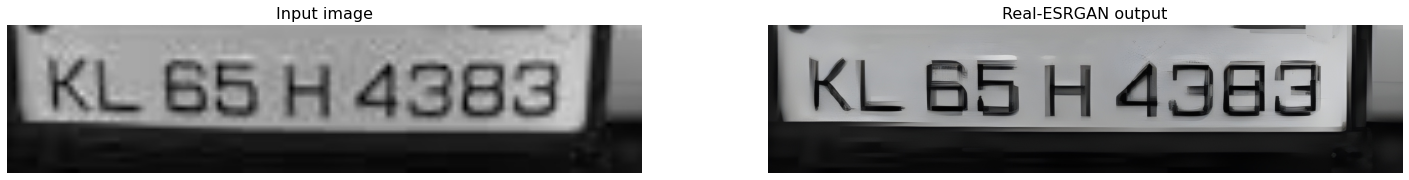

In [30]:
# utils for visualization
import cv2
import matplotlib.pyplot as plt
def display(img1, img2):
  fig = plt.figure(figsize=(25, 10))
  ax1 = fig.add_subplot(1, 2, 1) 
  plt.title('Input image', fontsize=16)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, 2, 2)
  plt.title('Real-ESRGAN output', fontsize=16)
  ax2.axis('off')
  ax1.imshow(img1)
  ax2.imshow(img2)
def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

# display each image in the upload folder
import os
import glob

input_folder = 'upload'
result_folder = 'results'
input_list = sorted(glob.glob(os.path.join(input_folder, '*')))
output_list = sorted(glob.glob(os.path.join(result_folder, '*')))
for input_path, output_path in zip(input_list, output_list):
  img_input = imread(input_path)
  img_output = imread(output_path)
  display(img_input, img_output)

In [31]:
cv2.imwrite('esroutput.jpg',img_output)
files.download('esroutput.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


# **pytesseract for Optical Character Recognization**

In [33]:
!pip install pytesseract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
import pytesseract
import shutil
import os
import random
try:
    from PIL import Image
except ImportError:
    import Image
from google.colab import files
uploaded = files.upload()


Saving esroutput.jpg to esroutput (1).jpg


In [35]:
extractedInformation = pytesseract.image_to_string(Image.open('esroutput.jpg'))

In [36]:
print(extractedInformation)

KL 65H 4383

 

